In [7]:
#!/usr/bin/env python3
import numpy as np
from scipy.optimize import minimize, linprog
from scipy.spatial import ConvexHull

#########################
# FIRI module functions
#########################

def chol3d(A):
    """
    Cholesky-like decomposition for a 3x3 matrix A.
    Returns L such that A = L * L^T.
    """
    L = np.zeros((3, 3))
    L[0, 0] = np.sqrt(A[0, 0])
    L[0, 1] = 0.0
    L[0, 2] = 0.0
    L[1, 0] = 0.5 * (A[0, 1] + A[1, 0]) / L[0, 0]
    L[1, 1] = np.sqrt(A[1, 1] - L[1, 0] * L[1, 0])
    L[1, 2] = 0.0
    L[2, 0] = 0.5 * (A[0, 2] + A[2, 0]) / L[0, 0]
    L[2, 1] = (0.5 * (A[1, 2] + A[2, 1]) - L[2, 0] * L[1, 0]) / L[1, 1]
    L[2, 2] = np.sqrt(A[2, 2] - L[2, 0] * L[2, 0] - L[2, 1] * L[2, 1])
    return L

def smoothedL1(mu, x):
    """
    Compute smoothed L1 penalty.
    Returns (success, f, df) where f is the function value and df its derivative.
    """
    if x < 0.0:
        return False, None, None
    elif x > mu:
        f = x - 0.5 * mu
        df = 1.0
        return True, f, df
    else:
        xdmu = x / mu
        sqrxdmu = xdmu * xdmu
        mumxd2 = mu - 0.5 * x
        f = mumxd2 * sqrxdmu * xdmu
        df = sqrxdmu * ((-0.5) * xdmu + 3.0 * mumxd2 / mu)
        return True, f, df

def costMVIE(x, data):
    """
    Cost and gradient for MVIE optimization.
    x is a vector of length 9:
      - p (3 elements): translation offset (will be added to interior point)
      - rtd (3 elements): square roots of diagonal elements of L (rtd > 0)
      - cde (3 elements): off-diagonal elements (L[1,0], L[2,1], L[2,0])
    data is a dictionary containing:
      - 'M': number of half-spaces (int)
      - 'smoothEps': smoothing epsilon (float)
      - 'penaltyWt': penalty weight (float)
      - 'A': an (M x 3) NumPy array
    Returns: cost, grad (a vector of same size as x)
    """
    M = data['M']
    smoothEps = data['smoothEps']
    penaltyWt = data['penaltyWt']
    A = data['A']  # shape (M,3)

    p = x[0:3]
    rtd = x[3:6]
    cde = x[6:9]

    gdp = np.zeros(3)
    gdrtd = np.zeros(3)
    gdcde = np.zeros(3)

    eps_db = np.finfo(float).eps
    L = np.array([[rtd[0] * rtd[0] + eps_db, 0.0, 0.0],
                  [cde[0], rtd[1] * rtd[1] + eps_db, 0.0],
                  [cde[2], cde[1], rtd[2] * rtd[2] + eps_db]])

    AL = A @ L   # shape (M,3)
    normAL = np.linalg.norm(AL, axis=1)  # shape (M,)
    normAL_safe = normAL.copy()
    normAL_safe[normAL_safe == 0] = 1e-8
    adjNormAL = (AL.T / normAL_safe).copy()  # shape (3,M)
    consViola = normAL + A @ p - 1.0  # shape (M,)

    cost = 0.0
    for i in range(M):
        ok, c_val, dc = smoothedL1(smoothEps, consViola[i])
        if ok:
            cost += c_val
            vec = dc * A[i, :]  # (3,)
            gdp += vec
            gdrtd += adjNormAL[:, i] * vec
            gdcde[0] += adjNormAL[0, i] * vec[1]
            gdcde[1] += adjNormAL[1, i] * vec[2]
            gdcde[2] += adjNormAL[0, i] * vec[2]

    cost *= penaltyWt
    gdp *= penaltyWt
    gdrtd *= penaltyWt
    gdcde *= penaltyWt

    cost -= np.log(L[0, 0]) + np.log(L[1, 1]) + np.log(L[2, 2])
    gdrtd[0] -= 1.0 / L[0, 0]
    gdrtd[1] -= 1.0 / L[1, 1]
    gdrtd[2] -= 1.0 / L[2, 2]

    gdrtd[0] *= 2.0 * rtd[0]
    gdrtd[1] *= 2.0 * rtd[1]
    gdrtd[2] *= 2.0 * rtd[2]

    grad = np.zeros_like(x)
    grad[0:3] = gdp
    grad[3:6] = gdrtd
    grad[6:9] = gdcde

    return cost, grad

def maxVolInsEllipsoid(hPoly, R, p, r):
    """
    Compute the maximum volume inscribed ellipsoid.
    hPoly: (M x 4) half-space inequalities (each row: [h0, h1, h2, h3])
    R: initial 3x3 rotation matrix
    p: initial interior point (3,)
    r: initial radii vector (3,)
    Returns (success, R, p, r)
    """
    M = hPoly.shape[0]
    normals = hPoly[:, 0:3]
    hNorm = np.linalg.norm(normals, axis=1, keepdims=True)
    Alp = np.hstack((normals / hNorm, np.ones((M, 1))))  # (M x 4)
    blp = -hPoly[:, 3:4] / hNorm

    c_lp = np.array([0.0, 0.0, 0.0, -1.0])
    res_lp = linprog(c_lp, A_ub=Alp, b_ub=blp, method='highs')
    if res_lp.status != 0 or res_lp.fun >= 0 or np.isinf(res_lp.fun):
        return False, R, p, r
    interior = res_lp.x[0:3]

    denom = blp - (Alp[:, 0:3] @ interior.reshape(-1, 1))
    denom[denom == 0] = 1e-8
    A_mv = (Alp[:, 0:3] / denom).reshape(M, 3)
    optData = {'M': M, 'smoothEps': 1.0e-2, 'penaltyWt': 1.0e+3, 'A': A_mv}

    Q = R @ np.diag(r * r) @ R.T
    L_init = chol3d(Q)
    x0 = np.zeros(9)
    x0[0:3] = p - interior
    x0[3] = np.sqrt(L_init[0, 0])
    x0[4] = np.sqrt(L_init[1, 1])
    x0[5] = np.sqrt(L_init[2, 2])
    x0[6] = L_init[1, 0]
    x0[7] = L_init[2, 1]
    x0[8] = L_init[2, 0]

    def fun_mv(x):
        cost, grad = costMVIE(x, optData)
        return cost, grad

    res = minimize(fun_mv, x0, method='L-BFGS-B', jac=True,
                   options={'maxiter': 100, 'gtol': 1e-7, 'min_step': 1e-32})
    if not res.success:
        print("FIRI WARNING:", res.message)

    x_opt = res.x
    p_new = x_opt[0:3] + interior
    L_opt = np.array([[x_opt[3]**2,       0.0,         0.0],
                      [x_opt[6],    x_opt[4]**2,         0.0],
                      [x_opt[8],    x_opt[7],    x_opt[5]**2]])
    U, S, Vt = np.linalg.svd(L_opt, full_matrices=True)
    if np.linalg.det(U) < 0:
        U[:, [0, 1]] = U[:, [1, 0]]
        S[[0, 1]] = S[[1, 0]]
    R_new = U
    r_new = S
    return True, R_new, p_new, r_new

def firi(bd, pc, a, b, iterations=4, epsilon=1.0e-5):
    """
    Compute the FIRI polyhedron.
    bd: (M x 4) half-space boundaries (each row: [h0, h1, h2, h3]).
    pc: (N x 3) array of obstacle points (each row is [x, y, z]).
    a, b: 3D endpoints (as 1D arrays of length 3) that satisfy bd * [point;1] <= 0.
    Returns (success, hPoly, tangentObstacle)
      - hPoly: (nH x 4) half-space inequalities.
      - tangentObstacle: (nH x 3) tangent (obstacle) points.
    """
    M = bd.shape[0]
    N = pc.shape[0]  # now N is the number of rows (points)
    ah = np.append(a, 1.0)
    bh = np.append(b, 1.0)
    if np.max(bd @ ah) > 0.0 or np.max(bd @ bh) > 0.0:
        return False, None, None

    R = np.eye(3)
    p = 0.5 * (a + b)
    r = np.ones(3)
    forwardH_list = []

    for loop in range(iterations):
        backward = R @ np.diag(r)
        forward = np.linalg.inv(np.diag(r)) @ R.T  # r^{-1} * R^T
        forwardB = bd[:, 0:3] @ backward  # shape: (M, 3)
        forwardD = bd[:, 3] + bd[:, 0:3] @ p  # shape: (M,)
        # For pc, which is (N x 3), transpose to (3 x N) for the multiplication.
        forwardPC = forward @ (pc.T - p.reshape(3, 1))  # (3 x N)
        fwd_a = forward @ (a - p)
        fwd_b = forward @ (b - p)

        norm_forwardB = np.linalg.norm(forwardB, axis=1)
        norm_forwardB_safe = norm_forwardB.copy()
        norm_forwardB_safe[norm_forwardB_safe == 0] = 1e-8
        distDs = np.abs(forwardD) / norm_forwardB_safe

        tangents = np.zeros((N, 4))
        distRs = np.zeros(N)
        for i in range(N):
            vec = forwardPC[:, i]
            distRs[i] = np.linalg.norm(vec)
            if distRs[i] != 0:
                tangents[i, 0:3] = vec / distRs[i]
            else:
                tangents[i, 0:3] = 0
            tangents[i, 3] = -distRs[i]
            if tangents[i, 0:3].dot(fwd_a) + tangents[i, 3] > epsilon:
                delta = vec - fwd_a
                if np.dot(delta, delta) > 1e-8:
                    proj = (delta.dot(fwd_a) / np.dot(delta, delta)) * delta
                    new_dir = fwd_a - proj
                    norm_new = np.linalg.norm(new_dir)
                    if norm_new > 1e-8:
                        tangents[i, 0:3] = new_dir / norm_new
                        distRs[i] = norm_new
                        tangents[i, 3] = -norm_new
            if tangents[i, 0:3].dot(fwd_b) + tangents[i, 3] > epsilon:
                delta = vec - fwd_b
                if np.dot(delta, delta) > 1e-8:
                    proj = (delta.dot(fwd_b) / np.dot(delta, delta)) * delta
                    new_dir = fwd_b - proj
                    norm_new = np.linalg.norm(new_dir)
                    if norm_new > 1e-8:
                        tangents[i, 0:3] = new_dir / norm_new
                        distRs[i] = norm_new
                        tangents[i, 3] = -norm_new
            if tangents[i, 0:3].dot(fwd_a) + tangents[i, 3] > epsilon:
                new_dir = np.cross(fwd_a - vec, fwd_b - vec)
                norm_new = np.linalg.norm(new_dir)
                if norm_new > 1e-8:
                    new_dir = new_dir / norm_new
                    tangents[i, 0:3] = new_dir
                    tangents[i, 3] = -new_dir.dot(fwd_a)
                    if tangents[i, 3] > 0.0:
                        tangents[i, :] *= -1.0

        bdFlags = np.ones(M, dtype=bool)
        pcFlags = np.ones(N, dtype=bool)
        nH = 0
        completed = False
        bdMinId = np.argmin(distDs)
        minSqrD = distDs[bdMinId]
        minSqrR = np.inf
        pcMinId = 0
        if N > 0:
            minSqrR = np.min(distRs)
            pcMinId = int(np.argmin(distRs))
        while not completed and (np.any(bdFlags) or np.any(pcFlags)):
            if minSqrD < minSqrR:
                chosen = forwardB[bdMinId, :]
                chosen_d = forwardD[bdMinId]
                bdFlags[bdMinId] = False
                forwardH_list.append(np.hstack((chosen, chosen_d)))
            else:
                forwardH_list.append(tangents[pcMinId, :])
                pcFlags[pcMinId] = False

            nH += 1
            completed = True
            candidate_bd = np.where(bdFlags)[0]
            if candidate_bd.size > 0:
                completed = False
                bdMinId = candidate_bd[np.argmin(distDs[candidate_bd])]
                minSqrD = distDs[bdMinId]
            else:
                minSqrD = np.inf
            candidate_pc = np.where(pcFlags)[0]
            minSqrR = np.inf
            if candidate_pc.size > 0:
                for j in candidate_pc:
                    if forwardH_list[-1][0:3].dot(forwardPC[:, j]) + forwardH_list[-1][3] > -epsilon:
                        pcFlags[j] = False
                candidate_pc = np.where(pcFlags)[0]
                if candidate_pc.size > 0:
                    completed = False
                    pcMinId = candidate_pc[np.argmin(distRs[candidate_pc])]
                    minSqrR = distRs[pcMinId]
            else:
                minSqrR = np.inf

        nH = len(forwardH_list)
        hPoly = np.zeros((nH, 4))
        for i in range(nH):
            h_forward = forwardH_list[i][0:3]
            hPoly[i, 0:3] = h_forward @ np.linalg.inv(forward)
            hPoly[i, 3] = forwardH_list[i][3] - hPoly[i, 0:3].dot(p)
        if loop == iterations - 1:
            break
        ok, R, p, r = maxVolInsEllipsoid(hPoly, R, p, r)
        if not ok:
            break

    tangentObstacle = np.full((nH, 3), np.inf)
    for i in range(nH):
        for j in range(N):
            signedDist = hPoly[i, 0:3].dot(pc[j, :]) + hPoly[i, 3]
            if np.abs(signedDist) < 0.1:
                tangentObstacle[i, :] = pc[j, :]
                break

    return True, hPoly, tangentObstacle

#########################
# geo_utils module functions
#########################

def findInterior(hPoly):
    """
    Given half-space inequalities hPoly (m x 4), find an interior point.
    Returns (success, interior) where interior is a 3D point.
    """
    m = hPoly.shape[0]
    normals = hPoly[:, 0:3]
    hNorm = np.linalg.norm(normals, axis=1, keepdims=True)
    A_lp = np.hstack((normals / hNorm, np.ones((m, 1))))
    b_lp = -hPoly[:, 3:4] / hNorm
    c = np.array([0.0, 0.0, 0.0, -1.0])
    res = linprog(c, A_ub=A_lp, b_ub=b_lp, method='highs')
    if res.status == 0 and res.fun < 0 and not np.isinf(res.fun):
        interior = res.x[0:3]
        return True, interior
    else:
        return False, None

def checkInterior(hPolys, query):
    """
    Check if a query point is inside all half-spaces defined in hPolys.
    hPolys: (m x 4) array.
    """
    for i in range(hPolys.shape[0]):
        normal = hPolys[i, 0:3]
        d = hPolys[i, 3]
        if normal.dot(query) + d > -1e-5:
            return False
    return True

def overlap(hPoly0, hPoly1, eps=1.0e-6):
    """
    Check if two polyhedra (defined by half-space inequalities) overlap.
    """
    m = hPoly0.shape[0]
    n = hPoly1.shape[0]
    A_lp = np.vstack((hPoly0[:, 0:3], hPoly1[:, 0:3]))
    A_lp = np.hstack((A_lp, np.ones((m+n, 1))))
    b_lp = np.vstack((-hPoly0[:, 3:4], -hPoly1[:, 3:4])).flatten()
    c = np.array([0.0, 0.0, 0.0, -1.0])
    res = linprog(c, A_ub=A_lp, b_ub=b_lp, method='highs')
    if res.status == 0 and res.fun < -eps and not np.isinf(res.fun):
        return True
    else:
        return False

def findDeepestPointOverlap(hPoly0, hPoly1, eps=1.0e-6):
    """
    Find the deepest overlapping point between two polyhedra.
    Returns (success, deepestPoint)
    """
    m = hPoly0.shape[0]
    n = hPoly1.shape[0]
    A_lp_top = hPoly0[:, 0:3]
    hNorm0 = np.linalg.norm(A_lp_top, axis=1, keepdims=True)
    A_lp_top = A_lp_top / hNorm0
    b_top = -hPoly0[:, 3:4] / hNorm0

    A_lp_bot = hPoly1[:, 0:3]
    hNorm1 = np.linalg.norm(A_lp_bot, axis=1, keepdims=True)
    A_lp_bot = A_lp_bot / hNorm1
    b_bot = -hPoly1[:, 3:4] / hNorm1

    A_lp = np.vstack((A_lp_top, A_lp_bot))
    A_lp = np.hstack((A_lp, np.ones((m+n, 1))))
    b_lp = np.vstack((b_top, b_bot)).flatten()

    c = np.array([0.0, 0.0, 0.0, -1.0])
    res = linprog(c, A_ub=A_lp, b_ub=b_lp, method='highs')
    if res.status == 0 and res.fun < -eps and not np.isinf(res.fun):
        deepestPoint = res.x[0:3]
        return True, deepestPoint
    else:
        return False, None

def filterVs(rV, epsilon):
    """
    Remove duplicate vertices from rV (3 x N) within resolution epsilon.
    Returns filtered vertices (3 x N_filtered).
    """
    # Determine resolution scale
    mag = max(np.abs(rV).max(), 1.0)
    res_scale = mag * max(epsilon/mag, np.finfo(float).eps)
    seen = set()
    filtered = []
    for i in range(rV.shape[1]):
        quanti = tuple(np.round(rV[:, i] / res_scale).astype(int))
        if quanti not in seen:
            seen.add(quanti)
            filtered.append(rV[:, i])
    if filtered:
        return np.column_stack(filtered)
    else:
        return np.empty((3,0))

def enumerateVs(hPoly, inner=None, epsilon=1.0e-6):
    """
    Enumerate vertices of the polyhedron defined by hPoly.
    If inner is not given, compute an interior point.
    Returns (success, vPoly) where vPoly is (3 x N) vertices.
    """
    if inner is None:
        ok, inner = findInterior(hPoly)
        if not ok:
            return False, None
    # Compute b vector
    b_vec = -hPoly[:, 3] - hPoly[:, 0:3] @ inner
    # Avoid division by zero
    b_vec_safe = b_vec.copy()
    b_vec_safe[np.abs(b_vec_safe) < 1e-8] = 1e-8
    A_transpose = (hPoly[:, 0:3].T / b_vec_safe).copy()  # shape (3 x m)
    # Use ConvexHull from scipy.spatial
    try:
        hull = ConvexHull(A_transpose.T, qhull_options="QJ")
    except Exception as e:
        print("QuickHull failed:", e)
        return False, None
    # For each facet (triangle) in the hull, compute a vertex candidate.
    rV = []
    for simplex in hull.simplices:
        pts = A_transpose[:, simplex]
        # Use the three points to compute a normal.
        # Here we take point2 - point1 and point3 - point1
        edge0 = pts[:, 1] - pts[:, 0]
        edge1 = pts[:, 2] - pts[:, 0]
        normal = np.cross(edge0, edge1)
        norm_normal = np.linalg.norm(normal)
        if norm_normal < 1e-8:
            continue
        normal = normal / norm_normal
        # Recover vertex candidate from the relation: vertex = normal / (normal.dot(point))
        denom = normal.dot(pts[:, 0])
        if np.abs(denom) < 1e-8:
            continue
        vertex = normal / denom
        rV.append(vertex)
    if len(rV) == 0:
        return False, None
    rV = np.column_stack(rV)
    rV = filterVs(rV, epsilon)
    # Translate vertices back by adding inner
    vPoly = rV + inner.reshape(3, 1)
    return True, vPoly

#########################
# Example usage
#########################
if __name__ == '__main__':
    bd = np.array([
        [ 1,  0,  0, -1],
        [-1,  0,  0, -1],
        [ 0,  1,  0, -1],
        [ 0, -1,  0, -1],
        [ 0,  0,  1, -1],
        [ 0,  0, -1, -1],
    ], dtype=float)
    # pc is now an (N x 3) array
    pc = np.array([
        [1,  1,  1],
        [1,  1, -1],
        [1, -1,  1],
        [1, -1, -1],
        [-1, 1,  1],
        [-1, 1, -1],
        [-1,-1,  1],
        [-1,-1, -1]
    ], dtype=float)
    a = np.array([0.5, 0.5, 0.5])
    b = np.array([-0.5, -0.5, -0.5])

    success, hPoly, tangentObstacle = firi(bd, pc, a, b)
    if success:
        print("FIRI computed hPoly:")
        print(hPoly)
        print("Tangent obstacle points:")
        print(tangentObstacle)
    else:
        print("FIRI failed.")


FIRI computed hPoly:
[[ 1.00012965  0.          0.         -1.        ]
 [-1.00012965  0.          0.         -1.        ]
 [ 0.          1.00012965  0.         -1.        ]
 [ 0.         -1.00012965  0.         -1.        ]
 [ 0.          0.          1.00012965 -1.        ]
 [ 0.          0.         -1.00012965 -1.        ]
 [ 1.00025932  0.          0.         -1.        ]
 [-1.00025932  0.          0.         -1.        ]
 [ 0.          1.00025932  0.         -1.        ]
 [ 0.         -1.00025932  0.         -1.        ]
 [ 0.          0.          1.00025932 -1.        ]
 [ 0.          0.         -1.00025932 -1.        ]
 [ 1.          0.          0.         -1.        ]
 [-1.          0.          0.         -1.        ]
 [ 0.          1.          0.         -1.        ]
 [ 0.         -1.          0.         -1.        ]
 [ 0.          0.          1.         -1.        ]
 [ 0.          0.         -1.         -1.        ]
 [ 1.00025932  0.          0.         -1.        ]
 [-1.00025

/tmp/ipykernel_11762/3637311663.py:159: OptimizeWarning: Unknown solver options: min_step
  res = minimize(fun_mv, x0, method='L-BFGS-B', jac=True,


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull
import plotly.graph_objects as go

def plot_ellipsoid_plotly(center, radii, rotation, color='cyan', opacity=0.3, resolution=50):
    """
    Create a Plotly surface mesh for an ellipsoid given its center, radii, and rotation.
    Returns a Plotly Surface object.
    """
    u = np.linspace(0, 2*np.pi, resolution)
    v = np.linspace(0, np.pi, resolution)
    u, v = np.meshgrid(u, v)
    # Parametric equations for the ellipsoid before rotation/translation.
    x = radii[0] * np.cos(u) * np.sin(v)
    y = radii[1] * np.sin(u) * np.sin(v)
    z = radii[2] * np.cos(v)
    # Flatten and apply rotation.
    pts = np.vstack((x.flatten(), y.flatten(), z.flatten()))
    pts_rot = rotation @ pts
    x_rot = pts_rot[0, :].reshape((resolution, resolution)) + center[0]
    y_rot = pts_rot[1, :].reshape((resolution, resolution)) + center[1]
    z_rot = pts_rot[2, :].reshape((resolution, resolution)) + center[2]
    ellipsoid = go.Surface(x=x_rot, y=y_rot, z=z_rot, colorscale=[[0, color],[1, color]],
                           opacity=opacity, showscale=False)
    return ellipsoid

def plot_polyhedron_plotly(hPoly, color='blue', opacity=0.5):
    """
    Enumerate the vertices of the polyhedron defined by hPoly and return a Plotly Mesh3d object.
    """
    success, vPoly = enumerateVs(hPoly)
    if not success or vPoly.shape[1] < 4:
        print("Could not compute vertices for polyhedron.")
        return None
    vertices = vPoly.T  # each row is a vertex
    try:
        hull = ConvexHull(vertices)
    except Exception as e:
        print("ConvexHull error:", e)
        return None

    x, y, z = vertices[:,0], vertices[:,1], vertices[:,2]
    # hull.simplices gives the indices of vertices for each triangular face.
    i = hull.simplices[:, 0]
    j = hull.simplices[:, 1]
    k = hull.simplices[:, 2]
    mesh = go.Mesh3d(x=x, y=y, z=z, i=i, j=j, k=k,
                     color=color, opacity=opacity, alphahull=0)
    return mesh

def plot_obstacles_plotly(obstacle_points, color='red', size=5):
    """
    Return a Plotly Scatter3d object for obstacle (tangent) points.
    """
    # Filter out infinite values
    mask = ~np.any(np.isinf(obstacle_points), axis=1)
    if np.sum(mask) == 0:
        return None
    pts = obstacle_points[mask, :]
    scatter = go.Scatter3d(
        x=pts[:,0], y=pts[:,1], z=pts[:,2],
        mode='markers',
        marker=dict(color=color, size=size)
    )
    return scatter


if __name__ == '__main__':
    # Create a simple half-space representation for a cube:
    bd = np.array([
        [ 1,  0,  0, -1],
        [-1,  0,  0, -1],
        [ 0,  1,  0, -1],
        [ 0, -1,  0, -1],
        [ 0,  0,  1, -1],
        [ 0,  0, -1, -1],
    ], dtype=float)
    # Create a point cloud (for example, vertices of a cube).
    # Ensure pc is an (N x 3) array.
    len_pc = 10
    pc_x = np.random.uniform(-1, 1, len_pc).reshape(len_pc,1)
    pc_y = np.random.uniform(-1, 1, len_pc).reshape(len_pc,1)
    pc_z = np.random.uniform(-1, 1, len_pc).reshape(len_pc,1)

    pc = np.array([pc_x, pc_y, pc_z]).reshape(len_pc,3)
    # pc = np.array([
    #     [1,  0.5,  1],
    #     [0.7,  1, -1],
    #     [0.2, -1,  0.5],
    #     [1, -0.8, -1],
    #     [-1, 1,  1],
    #     [-1, 0.6, -1],
    #     [-1,-1,  0.3],
    #     [-1,-1, -1]
    # ], dtype=float)
    print(pc.shape)
    # Endpoints a and b inside the cube.
    a = np.array([0.5, 0.5, 0.5])
    b = np.array([-0.5, -0.5, -0.5])
    
    # Run FIRI (here using a dummy firi() function for demonstration)
    success, hPoly, tangentObstacle = firi(bd, pc, a, b)
    if not success:
        print("FIRI algorithm failed!")
        exit(1)
    
    # For demonstration, we assume the inscribed ellipsoid has these parameters:
    ellipsoid_center = 0.5 * (a + b)  # midpoint
    ellipsoid_radii = np.array([0.8, 0.6, 0.4])  # dummy values
    ellipsoid_R = np.eye(3)  # identity rotation for demonstration

    # Create Plotly objects.
    ellipsoid_surf = plot_ellipsoid_plotly(ellipsoid_center, ellipsoid_radii, ellipsoid_R, color='cyan', opacity=0.3)
    poly_mesh = plot_polyhedron_plotly(hPoly, color='blue', opacity=0.5)
    obstacles_scatter = plot_obstacles_plotly(tangentObstacle, color='red', size=5)

    # Build the Plotly figure.
    fig = go.Figure()
    if poly_mesh is not None:
        fig.add_trace(poly_mesh)
    if obstacles_scatter is not None:
        fig.add_trace(obstacles_scatter)
    fig.add_trace(ellipsoid_surf)

    # Set axis labels.
    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='data'
        ),
        title="Polyhedron, Obstacle Points, and Inscribed Ellipsoid"
    )
    # Show the figure in your browser.
    fig.show()

(10, 3)
FIRI WARNING: ABNORMAL_TERMINATION_IN_LNSRCH
FIRI WARNING: STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
FIRI WARNING: STOP: TOTAL NO. of ITERATIONS REACHED LIMIT


/tmp/ipykernel_11762/3637311663.py:159: OptimizeWarning:

Unknown solver options: min_step



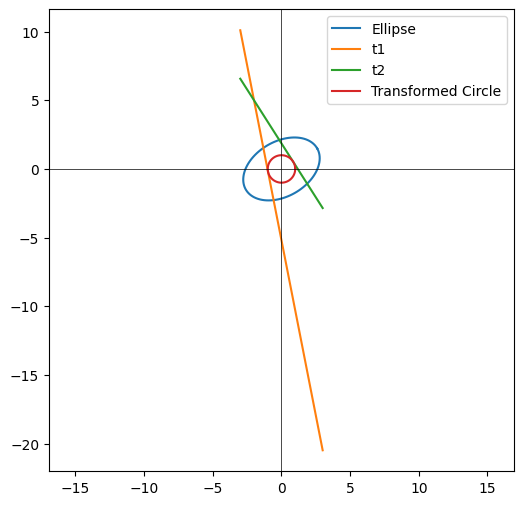

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Ellipse parameters
a, b = 3, 2  # Semi-axes lengths
theta = np.pi / 6  # Rotation angle (30 degrees)

# Generate ellipse points
t = np.linspace(0, 2*np.pi, 100)
x = a * np.cos(t)
y = b * np.sin(t)

# Rotation matrix
R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
ellipse_points = R @ np.vstack([x, y])

# Affine transformation to unit circle
A_inv = np.linalg.inv(R @ np.diag([a, b]))
circle_points = A_inv @ ellipse_points


d = np.array([-2.0, 5.0])

x_line = np.linspace(-3, 3, 100)  # X range

detm = np.sqrt((d[0]*d[1])**2 - (d[0]**2 -1)*(d[1]**2-1))
deno = (d[0]**2 - 1)
m1 = (d[0]*d[1] - detm)/deno
m2 = (d[0]*d[1] + detm)/deno
c1 = d[1] - m1*d[0]
c2 = d[1] - m2*d[0]

y_line1 = m1*x_line + c1
y_line2 = m2*x_line + c2

plt.figure(figsize=(6, 6))
plt.plot(ellipse_points[0], ellipse_points[1], label="Ellipse")
plt.plot(x_line, y_line1, label="t1")
plt.plot(x_line, y_line2, label="t2")
plt.plot(circle_points[0], circle_points[1], label="Transformed Circle")
plt.axhline(0, color="black", linewidth=0.5)
plt.axvline(0, color="black", linewidth=0.5)
plt.legend()
plt.axis("equal")
plt.show()


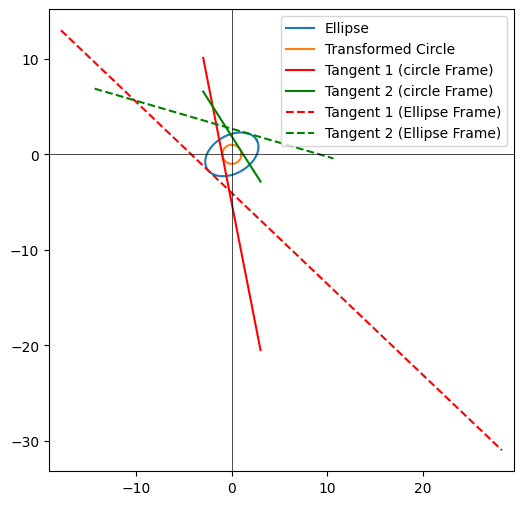

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Ellipse parameters
a, b = 3, 2  # Semi-axes lengths
theta = np.pi / 6  # Rotation angle (30 degrees)

# Generate ellipse points
t = np.linspace(0, 2*np.pi, 100)
x = a * np.cos(t)
y = b * np.sin(t)

# Rotation matrix
R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
ellipse_points = R @ np.vstack([x, y])

# Affine transformation to unit circle
A = R @ np.diag([a, b])  # Original transformation matrix
A_inv = np.linalg.inv(A)  # Inverse transformation (circle to ellipse)
circle_points = A_inv @ ellipse_points  # Transforming the ellipse into a unit circle

# External point in circle frame
d = np.array([-2.0, 5.0])

# Compute the slopes of the tangent lines in the circle frame
detm = np.sqrt((d[0]*d[1])**2 - (d[0]**2 -1)*(d[1]**2-1))
deno = (d[0]**2 - 1)
m1 = (d[0]*d[1] - detm) / deno
m2 = (d[0]*d[1] + detm) / deno
c1 = d[1] - m1*d[0]
c2 = d[1] - m2*d[0]

# Generate tangent lines in the circle frame
x_line = np.linspace(-3, 3, 100)  # X range
y_line1 = m1 * x_line + c1
y_line2 = m2 * x_line + c2

# Transform the tangent lines back to the ellipse frame
circle_tangent1 = np.vstack([x_line, y_line1])
circle_tangent2 = np.vstack([x_line, y_line2])

ellipse_tangent1 = A @ circle_tangent1  # Transform back to ellipse space
ellipse_tangent2 = A @ circle_tangent2  # Transform back to ellipse space

# Plot results
plt.figure(figsize=(6, 6))
plt.plot(ellipse_points[0], ellipse_points[1], label="Ellipse")
plt.plot(circle_points[0], circle_points[1], label="Transformed Circle")
plt.plot(x_line, y_line1,'r' , label="Tangent 1 (circle Frame)")
plt.plot(x_line, y_line2, 'g' , label="Tangent 2 (circle Frame)")
plt.plot(ellipse_tangent1[0], ellipse_tangent1[1], 'r--', label="Tangent 1 (Ellipse Frame)")
plt.plot(ellipse_tangent2[0], ellipse_tangent2[1], 'g--', label="Tangent 2 (Ellipse Frame)")

plt.axhline(0, color="black", linewidth=0.5)
plt.axvline(0, color="black", linewidth=0.5)
plt.legend()
plt.axis("equal")
plt.show()
